In [32]:

from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchgeo
from torchgeo.datasets import RasterDataset
from torchgeo.samplers import RandomGeoSampler

root = Path().resolve().parents[0]
sys.path.append(str(root))

from src.config import VHR_DIR, MASK_DIR 


In [33]:
# sjekk at VHR parthen er riktig 
print("VHR_DIR:", VHR_DIR)
list(VHR_DIR.glob("*.tif"))[:3]


VHR_DIR: /Users/cecilia/Desktop/NTNU/Fordypningsprosjekt/Land-Take-Prediction-Project-NINA-/data/raw/vhr


[PosixPath('/Users/cecilia/Desktop/NTNU/Fordypningsprosjekt/Land-Take-Prediction-Project-NINA-/data/raw/vhr/a-1-34144867248374_47-02619422462487_RGBY_Mosaic.tif'),
 PosixPath('/Users/cecilia/Desktop/NTNU/Fordypningsprosjekt/Land-Take-Prediction-Project-NINA-/data/raw/vhr/a-0-47134313698222_52-09242527089813_RGBY_Mosaic.tif'),
 PosixPath('/Users/cecilia/Desktop/NTNU/Fordypningsprosjekt/Land-Take-Prediction-Project-NINA-/data/raw/vhr/a-1-58467935875357_47-05443474717619_RGBY_Mosaic.tif')]

Definerer datasettet:

In [6]:
class HablossVHRDataset(RasterDataset):
    """TorchGeo Dataset for Habloss VHR imagery."""
    filename_glob = "*_RGBY_Mosaic.tif" 

    is_image = True
    separate_files = True

vhr_ds = HablossVHRDataset(paths=VHR_DIR)

print("Number of VHR tiles:", len(vhr_ds))


Number of VHR tiles: 6


In [16]:
# Check the dataset index to see if files have geospatial info
print("Dataset index:", vhr_ds.index)
print("\nBounds:", vhr_ds.bounds)

# Check one file directly
import rasterio
test_file = list(VHR_DIR.glob("*_RGBY_Mosaic.tif"))[0]
with rasterio.open(test_file) as src:
    print(f"\nFile: {test_file.name}")
    print(f"CRS: {src.crs}")
    print(f"Transform: {src.transform}")
    print(f"Bounds: {src.bounds}")

Dataset index: rtree.index.Index(bounds=[-1.588997543178626, -0.46653931815840555, 44.038928385998666, 52.2606687538444, 0.0, 9.223372036854776e+18], size=6)

Bounds: BoundingBox(minx=-1.588997543178626, maxx=-0.46653931815840555, miny=44.038928385998666, maxy=52.2606687538444, mint=0.0, maxt=9.223372036854776e+18)

File: a-1-34144867248374_47-02619422462487_RGBY_Mosaic.tif
CRS: EPSG:4326
Transform: | 0.00, 0.00,-1.35|
| 0.00,-0.00, 47.03|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=-1.3457829198090334, bottom=47.02325280015517, right=-1.3371321436229624, top=47.029154731571836)


## Simple Patching Without Geospatial Metadata

a simple approach that works directly with the image arrays, because of lack of geospatial metadata. Uses the idea of computing mean/std per channel som PyTorch tutorial. 

Helper function for computing dataset level mean over random patches 

In [34]:
@torch.no_grad()
def estimate_mean_std(vhr_dir, mask_dir, samples=2000, patch_size=128):
    tmp = SimpleHablossPatchDataset(vhr_dir, mask_dir, patch_size=patch_size,
                                    patches_per_image=1, mean=None, std=None, augment=False)
    C = 6
    s1 = torch.zeros(C)
    s2 = torch.zeros(C)
    n  = 0
    for i in range(samples):
        img, _ = tmp[i % len(tmp)]
        # simple 0-1 per-image to stabilize stats pass
        m = img.max()
        if m > 0: img = img / m
        # accumulate channelwise
        s1 += img.view(C, -1).mean(dim=1)
        s2 += img.view(C, -1).pow(2).mean(dim=1)
        n  += 1
    mean = (s1 / n).tolist()
    std  = (s2 / n - (s1 / n)**2).clamp_min(0).sqrt().tolist()
    return mean, std

mean, std = estimate_mean_std(VHR_DIR, MASK_DIR, samples=2000, patch_size=128)
print("mean:", mean)
print("std :", std)


Found 6 tile pairs
mean: [0.4026927351951599, 0.41661980748176575, 0.3574281930923462, 0.39302095770835876, 0.43123874068260193, 0.4329615533351898]
std : [0.20189687609672546, 0.1714923232793808, 0.1628580391407013, 0.2520349621772766, 0.2237759530544281, 0.2098092883825302]


## Create pytorch dataset for patching 

it uses the TorchGo concept of cutting random images on the go (with __getitem__) instaead of all at once.  

In [35]:
import random
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import rasterio

class SimpleHablossPatchDataset(Dataset):
    """
    Random 128x128 patches from HABLOSS VHR + matching mask.
    - Reads full VHR (6 bands) and mask (1 band, coarse)
    - Upsamples mask to VHR size (nearest)
    - Random crops aligned patches
    - Normalizes per channel if mean/std are given
    - Optional H/V flips
    """
    def __init__(self, vhr_dir, mask_dir, patch_size=128, patches_per_image=10,
                 mean=None, std=None, augment=False):
        self.vhr_dir = Path(vhr_dir)
        self.mask_dir = Path(mask_dir)
        self.patch_size = patch_size
        self.patches_per_image = patches_per_image
        self.mean = torch.tensor(mean, dtype=torch.float32) if mean is not None else None  # len=6
        self.std  = torch.tensor(std,  dtype=torch.float32) if std  is not None else None
        self.augment = augment

        # Match files by base id
        vhrs = sorted(self.vhr_dir.glob("*_RGBY_Mosaic.tif"))
        self.pairs = []
        for v in vhrs:
            base = v.name.replace("_RGBY_Mosaic.tif", "")
            m = self.mask_dir / f"{base}_mask.tif"
            if m.exists():
                self.pairs.append((v, m))
        if not self.pairs:
            raise RuntimeError("No VHR+mask pairs found.")

        print(f"Found {len(self.pairs)} tile pairs")

    def __len__(self):
        return len(self.pairs) * self.patches_per_image

    def __getitem__(self, idx):
        file_idx = idx // self.patches_per_image
        vhr_path, mask_path = self.pairs[file_idx]

        # read full rasters
        with rasterio.open(vhr_path) as src:
            img = src.read()  # (C,H,W)  C=6
        with rasterio.open(mask_path) as src_m:
            mask = src_m.read(1)  # (h,w) ints {0,1}

        # to torch
        img  = torch.from_numpy(img).float()               # (6,H,W)
        mask = torch.from_numpy(mask).unsqueeze(0).float() # (1,h,w)

        # upsample mask to image size (nearest to preserve labels)
        _, H, W = img.shape
        mask_up = F.interpolate(mask.unsqueeze(0), size=(H, W), mode="nearest").squeeze(0).squeeze(0)  # (H,W)
        mask_up = mask_up.long()

        # random crop coords
        ps = self.patch_size
        if H < ps or W < ps:
            # pad (rare)
            pad_h, pad_w = max(0, ps-H), max(0, ps-W)
            img  = F.pad(img, (0, pad_w, 0, pad_h))             # pad right/bottom
            mask_up = F.pad(mask_up, (0, pad_w, 0, pad_h))
            H, W = img.shape[1], img.shape[2]
        y = random.randint(0, H-ps)
        x = random.randint(0, W-ps)

        img_patch  = img[:, y:y+ps, x:x+ps]              # (6,ps,ps)
        mask_patch = mask_up[y:y+ps, x:x+ps]             # (ps,ps)

        # normalization
        if self.mean is not None and self.std is not None:
            # per-channel standardization
            img_patch = (img_patch - self.mean[:, None, None]) / (self.std[:, None, None] + 1e-6)
        else:
            # simple 0–1 scaling per image
            m = img_patch.max()
            if m > 0:
                img_patch = img_patch / m

        # simple augments
        if self.augment and random.random() < 0.5:
            img_patch  = torch.flip(img_patch,  dims=[2])  # horizontal
            mask_patch = torch.flip(mask_patch, dims=[1])
        if self.augment and random.random() < 0.5:
            img_patch  = torch.flip(img_patch,  dims=[1])  # vertical
            mask_patch = torch.flip(mask_patch, dims=[0])

        return img_patch, mask_patch


Initialize dataset

In [36]:
train_ds = SimpleHablossPatchDataset(VHR_DIR, MASK_DIR, patch_size=128, patches_per_image=20,
                                     mean=mean, std=std, augment=True)
val_ds   = SimpleHablossPatchDataset(VHR_DIR, MASK_DIR, patch_size=128, patches_per_image=10,
                                     mean=mean, std=std, augment=False)


Found 6 tile pairs
Found 6 tile pairs


Patch shape: torch.Size([6, 128, 128])


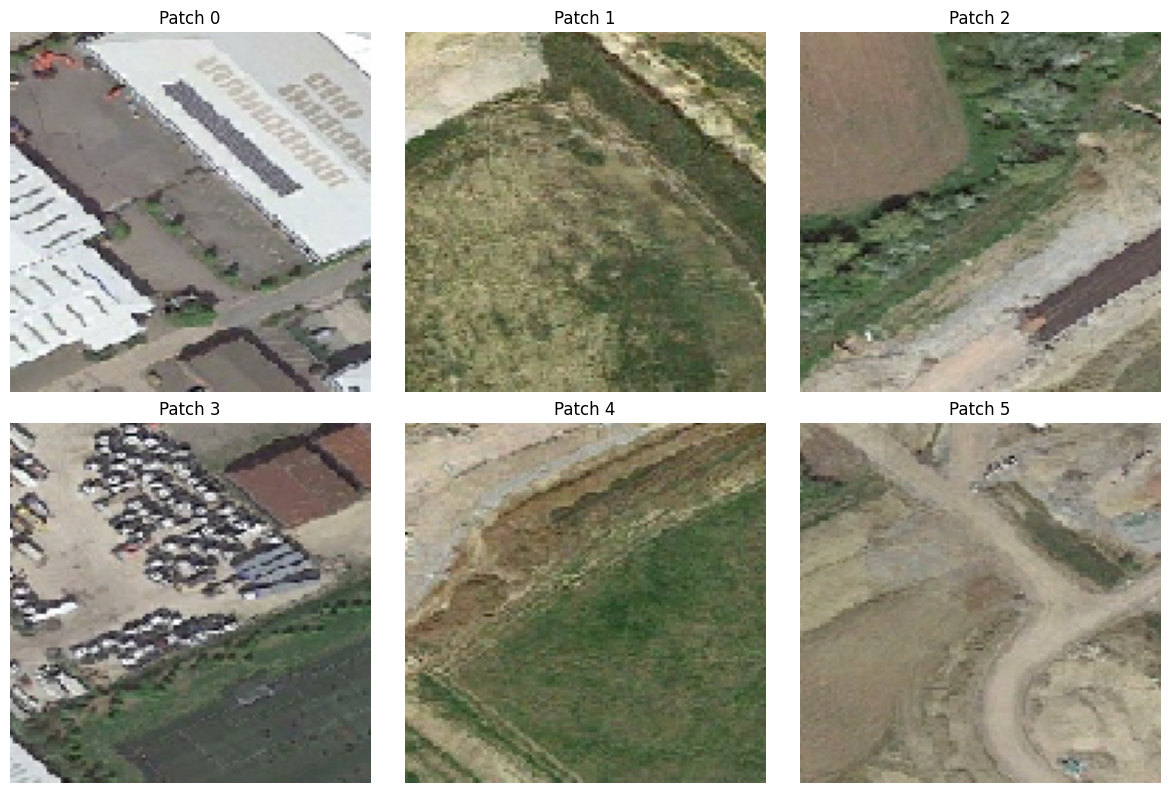

In [37]:
# Test the simple dataset
sample_patch = simple_ds[0]
print("Patch shape:", sample_patch.shape)

# Visualize a few patches
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    patch = simple_ds[i].numpy()
    
    # Use first 3 bands as RGB (before)
    rgb = patch[0:3]
    rgb = np.transpose(rgb, (1, 2, 0))
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
    
    ax.imshow(rgb)
    ax.set_title(f"Patch {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()